In [5]:
# coding = utf-8
# @Time    : 2022-10-17  01:27:03
# @Author  : zhaosheng@nuaa.edu.cn
# @Describe: 可视化肿瘤位置.

import numpy as np
import ants
import os
from IPython import embed
from monai.networks.blocks import Warp
import torch
import matplotlib.pyplot as plt

# cfg
from cfg import real_nii_path
from cfg import tumor_path
from cfg import output_path
from cfg import EPOCH

warp_layer = Warp()


def get_result(output_path, epoch, type="_ddf_fake"):
    return sorted(
        [
            os.path.join(output_path, _file)
            for _file in os.listdir(output_path)
            if _file.startswith(f"{epoch}_") and str(type) in _file
        ],
        key=lambda x: x.split("_")[1],
    )


def get_loc(ddf, ct, mask):
    assert ct.shape == mask.shape

    mean_loc = np.mean(mask)
    # plt.figure()
    # plt.plot(mask[:,:,int(mean_loc[2])])
    # plt.show()

    # plt.figure()
    # plt.plot(ct[:,:,int(mean_loc[2])])
    # plt.show()

    ddf_x = ddf[0]
    ddf_y = ddf[1]
    ddf_z = ddf[2]
    ct[mask < 0.5] = 0
    ddf_x[mask < 0.5] = 0
    ddf_y[mask < 0.5] = 0
    ddf_z[mask < 0.5] = 0
    x_mean = np.mean(ddf_x[mask > 0])
    # print(ddf_x[mask>0].shape)
    y_mean = np.mean(ddf_y[mask > 0])
    z_mean = np.mean(ddf_z[mask > 0])
    # embed()
    return x_mean, y_mean, z_mean


def plot_loc(ddf, ct, mask):
    print(f" Type of ddf : {type(ddf)}")
    print(f" Type of ct : {type(ct)}")
    ct = ct + 1000
    ants.plot(mask)

    raw_mask = torch.FloatTensor(mask.numpy()).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
    ddf = torch.tensor(ddf).cuda().unsqueeze(dim=0)
    print(raw_mask.shape)
    print(ddf.shape)
    new_mask_array = warp_layer(raw_mask, ddf).cpu().detach().numpy()[0, 0]
    print(new_mask_array.shape)
    new_mask = mask.new_image_like(new_mask_array)

    ants.plot(new_mask)




/home/lyxx/anaconda3/envs/fnet/lib/python3.8/site-packages/monai/networks/blocks/warp.py:66: UserWarning:

monai.networks.blocks.Warp: Using PyTorch native grid_sample.



**344311
	#T5
 Type of ddf : <class 'numpy.ndarray'>
 Type of ct : <class 'ants.core.ants_image.ANTsImage'>


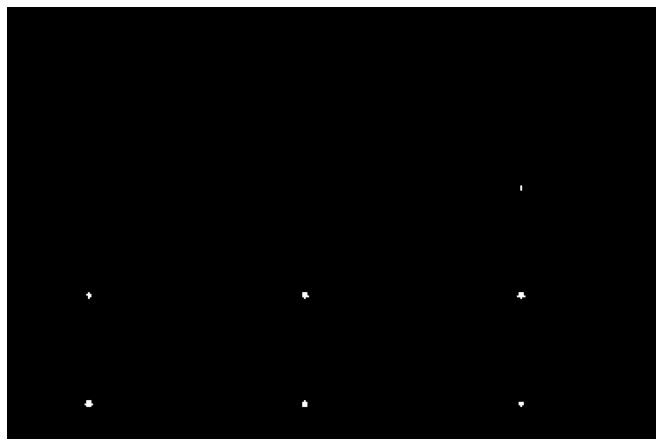

torch.Size([1, 1, 128, 128, 64])
torch.Size([1, 3, 128, 128, 64])
(128, 128, 64)


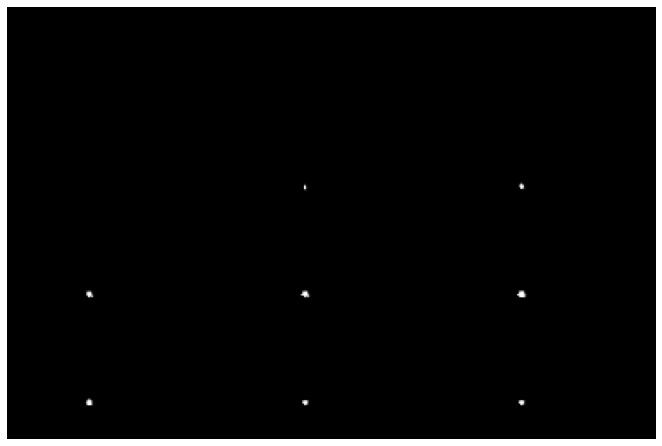

In [6]:

fake_images = get_result(output_path, EPOCH, "_image_fake")
real_images = get_result(output_path, EPOCH, "_image_real")
fake_ddfs = get_result(output_path, EPOCH, "_ddf_fake")
real_ddfs = get_result(output_path, EPOCH, "_ddf_real")

error = []
for index in range(len(real_ddfs)):
    pname = fake_images[index].split("/")[-1].split("_")[1]
    print(f"**{pname}")
    ddfs_fake = np.load(
        os.path.join(output_path, f"{EPOCH}_{pname}_ddf_fake.npy")
    ).reshape((9, 3, 128, 128, 64))
    ddfs_real = np.load(
        os.path.join(output_path, f"{EPOCH}_{pname}_ddf_real.npy")
    ).reshape((9, 3, 128, 128, 64))
    ct = ants.image_read(
        os.path.join(real_nii_path, f"{pname}_t0.nii")
    )  # .numpy()
    mask = ants.image_read(
        os.path.join(tumor_path, f"{pname}_t0_Segmentation.seg.nrrd")
    )  # .numpy()
    i = 5

    print(f"\t#T{i}")
    ddf_fake = ddfs_fake[i]
    ddf_real = ddfs_real[i]
    plot_loc(ddf_fake, ct, mask)
    break